# **Construcción de modelo Random Forest**

# **Importación de librerías necesarias** 

In [70]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# **Carga de los datos**

In [71]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X_train = train.drop('class', axis=1)
y_train = train['class'].copy()
X_test = test.drop('class', axis=1)
y_test = test['class'].copy()

# **Optimización de hiperparámetros** 

## **Inicialización del modelo**

In [72]:
rf = RandomForestClassifier(n_estimators=50)

## **Configuración del entorno de la búsqueda**

In [73]:
# Definiendo los dominios de los hiperparámetros
param_dist = {"max_depth": [3, 9, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [74]:
# Numeros de muestras del espacio de hiperparametros a generar
samples = 50
randomCV = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=samples,cv=3)

## **Búsqueda aleatoria de hiperparámetros**

In [75]:
randomCV.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=50),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 9, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000000256D0490>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000000000D5495D0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000000000D53C9D0>})

In [76]:
#Mostrando los mejores parametros obtenidos
print(randomCV.best_params_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 9}


In [77]:
randomCV.cv_results_['mean_test_score']

array([0.86522363, 0.8815227 , 0.8683055 , 0.80105457, 0.86871629,
       0.80208182, 0.86768919, 0.88837128, 0.80625905, 0.79920557,
       0.80413616, 0.80358877, 0.79947962, 0.80324667, 0.75448529,
       0.88590567, 0.88207055, 0.86673024, 0.80331458, 0.86618247,
       0.84940401, 0.88179666, 0.87111347, 0.86481298, 0.79961608,
       0.85111629, 0.85029427, 0.86864812, 0.87008614, 0.88083797,
       0.88617958, 0.8818655 , 0.88652202, 0.87357869, 0.87570168,
       0.87837266, 0.8678945 , 0.87631804, 0.88932994, 0.7965346 ,
       0.86714127, 0.87809866, 0.79879413, 0.86440202, 0.79982246,
       0.86419654, 0.80509511, 0.88570047, 0.89104202, 0.87946832])

In [78]:
randomCV.score(X_test,y_test)

0.8909048067860509

# **Creación del modelo obtenido**

In [79]:
# Parametros obtenidos en la busqueda
params = randomCV.best_params_

In [80]:
randomCV.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 9}

## **Inicialización del modelo**

In [107]:
rf = RandomForestClassifier(n_estimators=50, **randomCV.best_params_)

In [108]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features=6, min_samples_leaf=3,
                       min_samples_split=9, n_estimators=50)

## **Predicción del modelo**

In [109]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# **Métricas del modelo** 

In [110]:
rf.score(X_test,y_test)

0.8939679547596607

In [111]:
# Accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred)

0.8939679547596607

In [112]:
# Matthew Correlation Coefficient
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, y_test_pred)

0.7917772546037323

In [113]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[2080,  109],
       [ 341, 1714]], dtype=int64)

In [114]:
# Reporte de clasificación
from sklearn.metrics import classification_report

model_report = classification_report(y_test, y_test_pred, target_names=['positive','negative'])

f = open('rf_model_report.txt','w')
f.writelines(model_report) 
f.close()

In [115]:
# Devolver la importancia de los features del modelo
importance = pd.Series(rf.feature_importances_, name = 'Gini')

# Devolver los nombre de los features
feature_names = pd.Series(X_train.columns, name = 'Feature')

In [116]:
# Combinar los nombre de los nombres de los features y los valores de Gini en un Dataframe
df = pd.concat([feature_names, importance], axis=1, names=['Feature', 'Gini'])
df

,Feature,Gini
0,AAC_A,0.005484
1,AAC_C,0.024753
2,AAC_D,0.016078
3,AAC_E,0.029338
4,AAC_F,0.004428
...,...,...
108,QSO1_SC_A,0.005571
109,QSO1_SC_K,0.017744
110,QSO1_SC_L,0.008883
111,QSO1_SC_R,0.005381


Text(0.5, 0, 'Feature Importance')

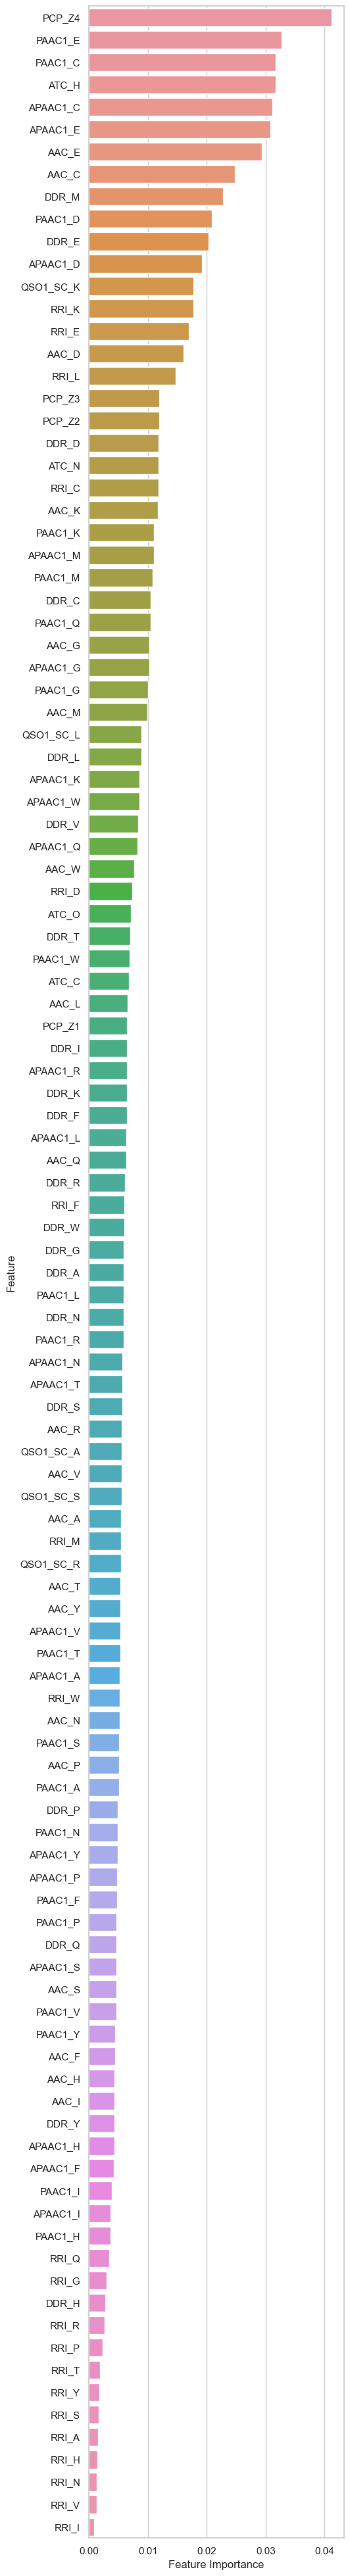

In [117]:
# Plot of feature importance
import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values('Gini', ascending=False) # Sort by Gini in descending order; Showing only the top 20 results

plt.figure(figsize=(5, 50))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = 'Gini', y = 'Feature', data = df_sorted)
plt.xlabel("Feature Importance")

<Axes: >

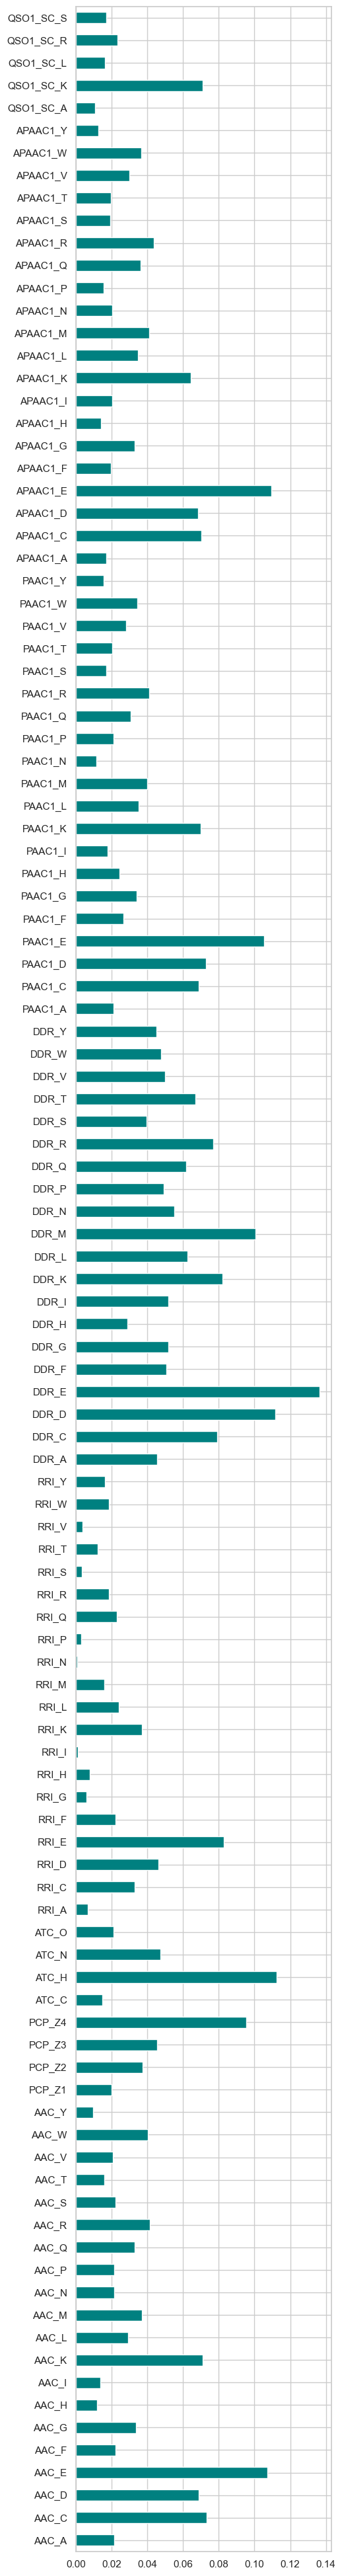

In [118]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(5, 50))
importances = mutual_info_classif(X_train, y_train)
feat_importances = pd.Series(importances, X_train.columns[0:len(X_train.columns)])
feat_importances.plot(kind='barh', color='teal')